<a href="https://colab.research.google.com/github/Ziqi-Li/GIS5122/blob/main/assignments/GIS5122_A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6
**Due date/time:** Apr 19th Fri 23:59pm

**Instruction**: Make a copy of this notebook and read through the questions and instructions. Write down code/text to perform the analysis.

**Submission**: After you finish working on this notebook, click File->Download->Download .ipynb

Please submit a notebook named A6_your_name.ipynb on Canvas.

## Instructions:

In this assignment, I hope to give you the maximum flexibility. You are free to train ANY 1 or several machine learning models on ANY dataset of your choice and to report the results. Here are some specific requirements:

1) Briefly explain how the selected machine learning model(s) work, using 2-3 sentences. (20%)

2) Provide a rationale for choosing this particular machine learning model(s) over others in 2-3 sentences. (20%)

3) Train and test your model(s). (30%)

4) Report the accuracy of your model(s) on both the training and test datasets. (10%)

5) Use simple comments or markdowns to explain your steps and code throughout the notebook. (20%)


Feel free to use the data from your final project for this assignment. Alternatively, if you are still wondering your project data or idea, you are welcome to use either the health data or the election data that we have previously used.

# Briefly explain how the selected machine learning model(s) work, using 2-3 sentences

Tree-based ensemble machine learning models, such as Random Forest and Gradient Boosting, work by combining multiple decision trees to make predictions. Each tree in the ensemble learns from a subset of the data and contributes to the final prediction through a voting or averaging mechanism. By leveraging the collective wisdom of diverse trees, these models enhance predictive accuracy and robustness, mitigating overfitting and improving generalization performance.

# Provide a rationale for choosing this particular machine learning model(s) over others in 2-3 sentences.

Tree-based ensemble methods, such as Random Forest and Gradient Boosting Machines (GBM), are chosen for their ability to manage missing values, and provide robustness against overfitting through their ensemble approach. These models are particularly beneficial because they offer high interpretability through feature importance and are less prone to be influenced by outliers, making them ideal for complex datasets where relationships between variables might be non-linear or where data quality varies. Additionally, their capability to perform both classification and regression tasks flexibly makes them versatile tools for a wide range of predictive analytics applications.

# Train and test of my model(s)

In [1]:
import geopandas as gpd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from hpsklearn import HyperoptEstimator,linear_regression, decision_tree_regressor
from hpsklearn import xgboost_regression,random_forest_regressor
from hyperopt import tpe
import shap

## Importing Health and Socio-Economic variables

In [2]:
health_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/cdc_health_county.csv"
health = pd.read_csv(health_url)

In [3]:
socio_demo_url = "https://raw.github.com/Ziqi-Li/GIS5122/main/data/acs_2019.csv"
socio_demo = pd.read_csv(socio_demo_url)

In [4]:
counties_url = "https://raw.github.com/Ziqi-Li/gis5122/master/data/us_counties.geojson"
counties = gpd.read_file(counties_url)

In [5]:
income_health = pd.merge(socio_demo, health, left_on = "county_id", right_on = "LocationID")

In [6]:
gdf_income_health = pd.merge(counties, income_health, on = "county_id")

## Target and Features

In [7]:
# Target
y = gdf_income_health['OBESITY']

# Features
X =gdf_income_health[['median_income', 'pct_black', 'pct_bach', 'sex_ratio', 'pct_65_over', 'pct_age_18_29', 'ln_pop_den' ]]

### Splitting train and test data

In [9]:
# I split the data into training (80%) and testing (20%). The model will be trained based on the training data and the testing data will be used to evaluate the model accuracy on unseen data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

### Hyperparameter Optimization for Regression Models

In [12]:
def train_any_model(X_train, y_train, any_regressor,max_evals=10):
    
    estim = HyperoptEstimator(regressor=any_regressor("myModel"), preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=240,n_jobs=-1)
    
    #5-fold cross validation of your training data
    estim.fit(X_train, y_train, n_folds=5, cv_shuffle=True, random_state=130)
    return estim

## XGBoost

In [13]:
%%time
xgb_models = train_any_model(X_train, y_train, xgboost_regression)

best_xgb = xgb_models.best_model()['learner']

# Make predictions on the training set
xgb_train_pred = best_xgb.predict(X_train)

# Make predictions on test set
xgb_pred = best_xgb.predict(X_test)

100%|██████████| 10/10 [00:17<00:00, 17.53s/trial, best loss: 0.42448472368123014]
CPU times: total: 12.9 s
Wall time: 3min 44s


#### evaluating the performance and accuracy of Random Forest model(s) on both the training and test 

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

print("XGB - Train_R2:", r2_score(y_train, xgb_train_pred))
print("XGB - Test_R2:", r2_score(y_test, xgb_pred))


print("XGB - Train_MSE:", mean_squared_error(y_train, xgb_train_pred))
print("XGB - Tes_MSE:", mean_squared_error(y_test, xgb_pred))


XGB - Train_R2: 0.6625305654107284
XGB - Test_R2: 0.6094989789797509
XGB - Train_MSE: 6.670247896596728
XGB - Tes_MSE: 8.390249845992232


### Random Forest

In [15]:
%%time
rf_models = train_any_model(X_train, y_train, random_forest_regressor)

best_rf = rf_models.best_model()['learner']

# Make predictions on the training set
rf_train_pred = best_rf.predict(X_train)

# Make predictions 
rf_pred = best_rf.predict(X_test)

100%|██████████| 10/10 [00:12<00:00, 12.20s/trial, best loss: 0.43946212432194676]


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


CPU times: total: 6min 9s
Wall time: 11min 43s


#### evaluating the performance and accuracy of Random Forest model(s) on both the training and test 

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

print("RF - Train_R2:", r2_score(y_train, rf_train_pred))
print("RF - Test_R2:", r2_score(y_test, rf_pred))


print("RF - Train_MSE:", mean_squared_error(y_train, rf_train_pred))
print("RF - Test_MSE:", mean_squared_error(y_test, rf_pred))


RF - Train_R2: 0.8875658364677637
RF - Test_R2: 0.6009177035208919
RF - Train_MSE: 2.222316055731922
RF - Test_MSE: 8.574625919860106


### Decision Tree

In [17]:
%%time
dt_models = train_any_model(X_train, y_train, decision_tree_regressor)

best_dt = dt_models.best_model()['learner']

# Make predictions on the training set
dt_train_pred = best_dt.predict(X_train)

# Make predictions 
dt_pred = best_dt.predict(X_test)

100%|██████████| 10/10 [00:07<00:00,  7.44s/trial, best loss: 0.5402270762142415]
CPU times: total: 359 ms
Wall time: 1min 17s


C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\jacob\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


#### evaluating the performance and accuracy of Descision Tree model(s) on both the training and test 

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

print("DT - Train_R2:", r2_score(y_train, dt_train_pred))
print("DT - Test_R2:", r2_score(y_test, dt_pred))

print("DT - Train_MSE:", mean_squared_error(y_train, dt_train_pred))
print("DT - Test_MSE:", mean_squared_error(y_test, dt_pred))

DT - Train_R2: 0.5317782403326736
DT - Test_R2: 0.4848212486213146
DT - Train_MSE: 9.25463134568896
DT - Test_MSE: 11.069057971014493


###  Evaluating the 3 model performances

In [19]:
from sklearn.metrics import mean_squared_error, r2_score

print("XGB - Test_R2:", r2_score(y_test, xgb_pred))

print("RF - Test_R2:", r2_score(y_test, rf_pred))

print("DT - Test_R2:", r2_score(y_test, dt_pred))

XGB - Test_R2: 0.6094989789797509
RF - Test_R2: 0.6009177035208919
DT - Test_R2: 0.4848212486213146


In [20]:
print("XGB - MSE:", mean_squared_error(y_test, xgb_pred))
print("RF - MSE:", mean_squared_error(y_test, rf_pred))
print("DT - MSE:", mean_squared_error(y_test, dt_pred))

XGB - MSE: 8.390249845992232
RF - MSE: 8.574625919860106
DT - MSE: 11.069057971014493


##  XGBoost is chosen to be the best model in predicting Obesity with the socio-demography variables used because it had the highest R2 and lowest MSE value

## Using shap to explain the prediction

In [21]:
# Initialize the TreeExplainer with the best trained model
explainer = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the entire gdf_income_health dataset.
shap_values = explainer(X)

In [22]:
total_y_pred = best_xgb.predict(X)

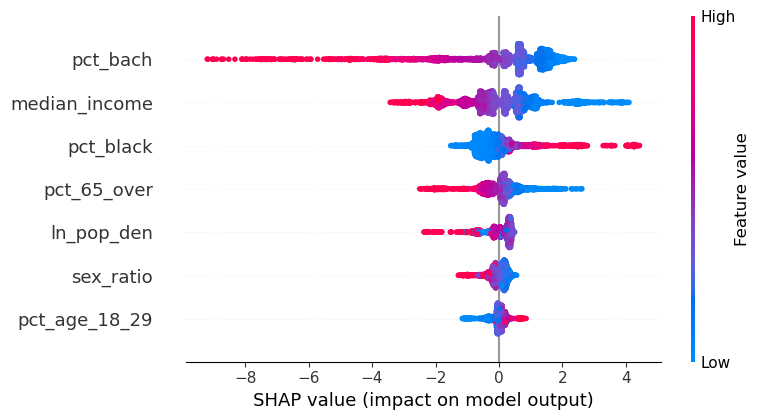

In [23]:
shap.summary_plot(shap_values, X)